In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.image import random_crop, random_flip_left_right, random_flip_up_down
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tqdm import tqdm
import random

In [2]:
import tensorflow as tf

In [3]:
x_train_paths = []
y_train_paths = []
x_val_paths = []
y_val_paths = []

all_paths = []
all_labels = []
data_dir = './dataset'
for label in os.listdir(data_dir):
    for image in os.listdir(data_dir + "/" + label):
        all_paths.append(data_dir + "/" + label + '/' +image)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)

x_train_paths = all_paths[:5000]
y_train = all_labels[:5000]
x_val_paths = all_paths[5000:]
y_val = all_labels[5000:]

In [4]:
def augment_image(image):
    image = tf.convert_to_tensor(np.uint8(image))    
    image = random_flip_left_right(image)
    image = random_flip_up_down(image)
    image = random_crop(image, (224, 224, 3))
    image = np.array(image)/255.0
    image = tf.convert_to_tensor(image)
    return image


In [5]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

2022-03-13 17:36:00.382944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 17:36:01.667306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10421 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


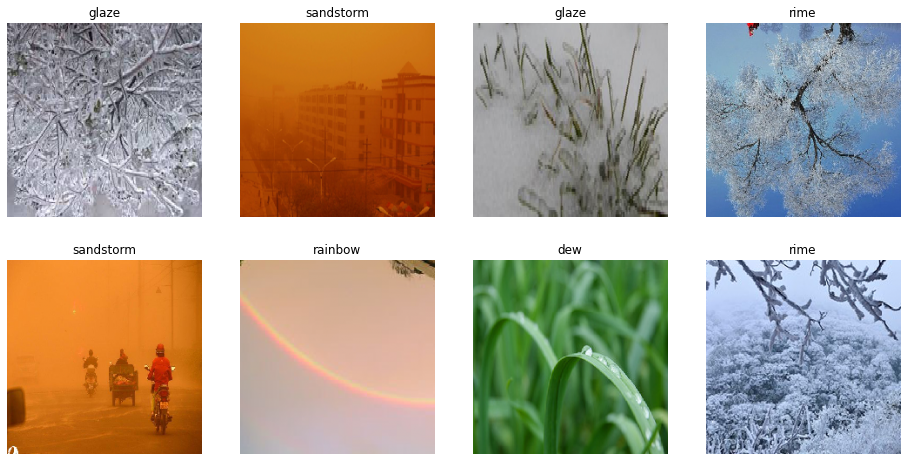

In [6]:
num_images = 9
images = open_images(x_train_paths[:num_images])
fig = plt.figure(figsize=(16, round(num_images/4)*4))
for x in range(1, num_images):
    fig.add_subplot(int(num_images/4), 4, x)
    plt.axis('off')
    plt.title(y_train[x])
    plt.imshow(images[x])
plt.show()

In [7]:
unique_labels = os.listdir(data_dir)
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [8]:
def data_gen(paths, labels, batch_size=32):
    
    if len(paths)!=len(labels):
        raise Exception('The length of paths is ',len(paths), ' but the length of labels is ', len(labels))
    
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths)
        batch_labels = labels[x:x+batch_size]
        batch_labels = encode_label(batch_labels)
        yield batch_images, batch_labels

In [9]:
#vgg16 = VGG16(input_shape=(256,256,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
#for layer in vgg16.layers:
#    layer.trainable = False

In [15]:
ratio = 16

model = Sequential()
model.add(Input(shape=(224,224,3)))

model.add(Conv2D(64, 3, activation='relu', padding="same", dilation_rate=2, input_shape=(224, 224, 3)))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(512, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())



model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(1024, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(1024, 3, activation='tanh', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(1024, 3, activation='relu', padding="same", dilation_rate=2))

model.add(GlobalAveragePooling2D())
model.add(Dense(len(unique_labels), activation='softmax'))
              
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 128)    

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

 46/156 [=======>......................] - ETA: 1:12 - loss: 1.3955 - accuracy: 0.5272

KeyboardInterrupt: 

In [13]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

59it [00:38,  1.52it/s]                        


In [14]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       122
           1       0.32      0.87      0.47       132
           2       0.85      0.61      0.71       327
           3       0.69      0.78      0.73       166
           4       0.54      0.18      0.27       175
           5       0.45      0.66      0.54       137
           6       0.67      0.77      0.72       222
           7       0.79      0.84      0.82       199
           8       0.51      0.38      0.44       151
           9       0.50      0.33      0.39       160
          10       0.79      0.32      0.46        71

    accuracy                           0.61      1862
   macro avg       0.64      0.59      0.58      1862
weighted avg       0.65      0.61      0.60      1862



In [10]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    print(init)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

In [29]:
ratio = 16

model2 = Sequential()
model2.add(Input(shape=(224,224,3)))

model2.add(Conv2D(64, 3, activation='relu', padding="same", dilation_rate=2, input_shape=(224, 224, 3)))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64//ratio,activation='relu'))
model2.add(Dense(64, activation='sigmoid'))
model2.add(multiply())

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(128, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128//ratio,activation='relu'))
model2.add(Dense(128, activation='sigmoid'))
model2.add(Conv2D(128, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128//ratio,activation='relu'))
model2.add(Dense(128, activation='sigmoid'))

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(256, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(256, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(256, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(512, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(512, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(512, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))



model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(1024, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(1024, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(1024, 3, activation='relu', padding="same", dilation_rate=2))

model2.add(GlobalAveragePooling2D())
model2.add(Dense(len(unique_labels), activation='softmax'))
              
model2.summary()

TypeError: multiply() missing 1 required positional argument: 'inputs'

In [21]:
#MeteCNN from Scratch
Inp=Input(shape=(224,224,3))
mex=Conv2D(64, 3, activation='relu', padding="same", dilation_rate=2, input_shape=(224, 224, 3))(Inp)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(128, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(128, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(256, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(256, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(256, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(512, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(512, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(512, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(1024, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(1024, 3, activation='tanh', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(1024, 3, activation='relu', padding="same", dilation_rate=2)(mex)
mex=GlobalAveragePooling2D()(mex)
mex=Dense(len(unique_labels), activation='softmax')(mex)
model3=Model(inputs=Inp,outputs=mex)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='batch_normalization_22/FusedBatchNormV3:0', description="created by layer 'batch_normalization_22'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='batch_normalization_23/FusedBatchNormV3:0', description="created by layer 'batch_normalization_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='batch_normalization_24/FusedBatchNormV3:0', description="created by layer 'batch_normalization_24'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='batch_normalization_25/FusedBatchNormV3:0', description="created by layer 'batch_normalization_25'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='batch_normalization_26/FusedBatchNormV3:0', description="created by layer 'batch_normalization_26'")
KerasTenso

In [22]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 224, 224, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_24 (Gl (None, 64)           0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

In [23]:
model3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model3.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

156/156 [==============================] - 117s 754ms/step - loss: 0.7219 - accuracy: 0.7468


In [25]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model3.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

59it [00:35,  1.64it/s]                        


In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.81      0.75        97
           1       0.63      0.49      0.55       176
           2       0.75      0.84      0.80       319
           3       0.87      0.82      0.84       172
           4       0.43      0.52      0.47       200
           5       0.55      0.63      0.59       139
           6       0.76      0.81      0.79       221
           7       0.72      0.82      0.76       173
           8       0.40      0.47      0.43       127
           9       0.60      0.29      0.39       164
          10       0.83      0.32      0.47        74

    accuracy                           0.65      1862
   macro avg       0.66      0.62      0.62      1862
weighted avg       0.66      0.65      0.65      1862



More Epoches

In [41]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [43]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

156/156 [==============================] - 80s 516ms/step - loss: 0.3031 - accuracy: 0.8880


In [44]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

59it [00:29,  2.03it/s]                        


In [45]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       100
           1       0.80      0.73      0.76       154
           2       0.86      0.68      0.76       337
           3       0.92      0.85      0.88       202
           4       0.41      0.60      0.49       166
           5       0.40      0.96      0.57       145
           6       0.75      0.83      0.79       206
           7       0.74      0.82      0.78       186
           8       0.77      0.30      0.43       138
           9       0.50      0.08      0.13       171
          10       0.59      0.79      0.68        57

    accuracy                           0.68      1862
   macro avg       0.70      0.68      0.65      1862
weighted avg       0.72      0.68      0.66      1862



In [46]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model3.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

156/156 [==============================] - 88s 566ms/step - loss: 0.2222 - accuracy: 0.9203


In [47]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model3.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)
        


59it [00:30,  1.95it/s]                        


In [48]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       100
           1       0.83      0.52      0.64       154
           2       0.75      0.81      0.78       337
           3       0.87      0.77      0.82       202
           4       0.45      0.45      0.45       166
           5       0.72      0.70      0.71       145
           6       0.77      0.83      0.80       206
           7       0.82      0.81      0.81       186
           8       0.46      0.77      0.58       138
           9       0.63      0.43      0.51       171
          10       0.63      0.74      0.68        57

    accuracy                           0.71      1862
   macro avg       0.71      0.70      0.69      1862
weighted avg       0.72      0.71      0.70      1862



In [49]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

 43/156 [=======>......................] - ETA: 1:00 - loss: 0.2620 - accuracy: 0.9004

KeyboardInterrupt: 

In [ ]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

In [ ]:
print(classification_report(y_true, y_pred))